# FTIR Data-Analysis
# Objective1: Create a model to predict the structure and composition of a new product

## Importing Frameworks

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow
import keras

Using TensorFlow backend.


## Importing Data and Visualizing Initial Spectroscopy

Importing Labels of products and Creating list of dataframes of the products' IR wavenumbers vs. Intensities and plotting there respective Initial Infrared Scpectroscopes(Initial 10 compounds)

Alkane  Alkene  Alkyne  Aromatic  Carboxylic acid  Ester  Ketone  \
Products                                                                     
C100016        0       0       0         1                0      0       0   
C100027        0       0       0         1                0      0       0   
C100094        1       0       0         1                1      0       0   
C100107        1       0       0         1                0      0       0   
C100129        1       0       0         1                0      0       0   

          Aldehyde  Ether  Nitrile  Alcohol  
Products                                     
C100016          0      0        0        0  
C100027          0      0        0        1  
C100094          0      1        0        1  
C100107          1      0        0        0  
C100129          0      0        0        0  
         IR Frequencies(nm)  Intensities(logarithmic episilon)
C100016                                                       
0              

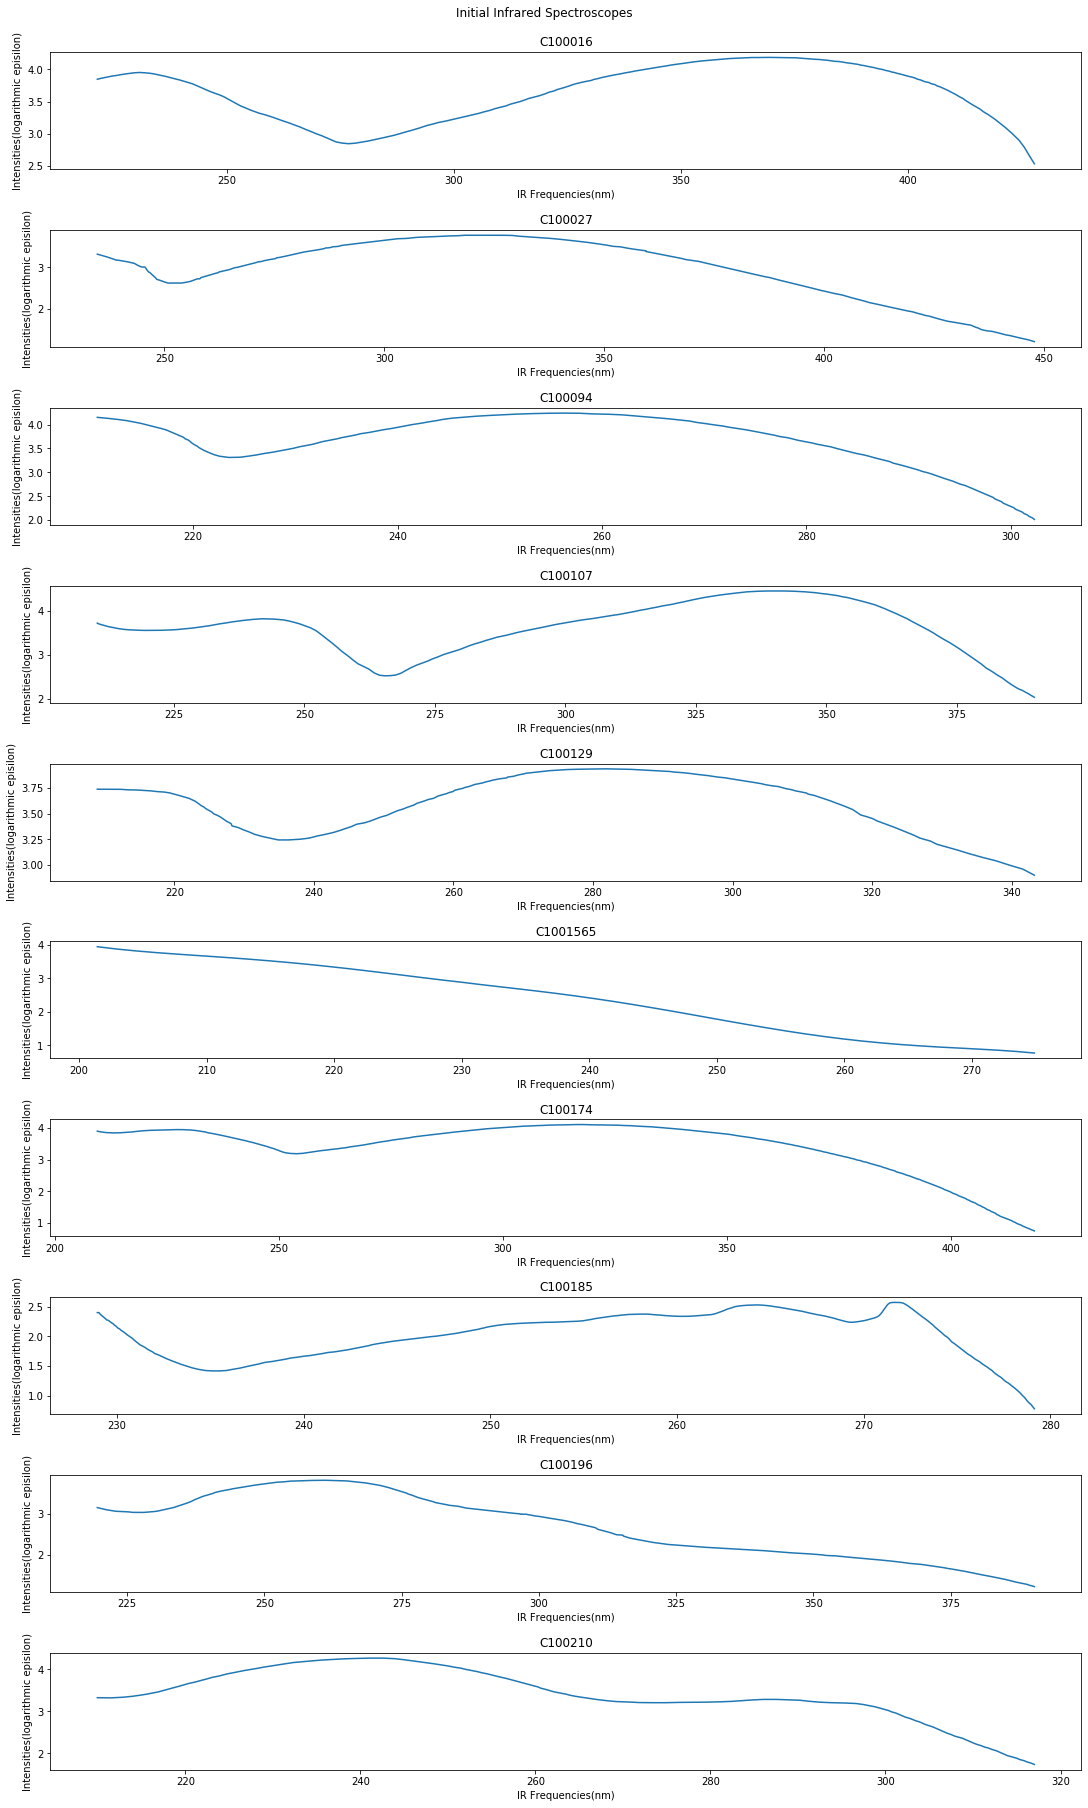

In [2]:
#Importing Generated Labels for the data
labels = pd.read_excel('./Data/labels.xlsx',header=0,index_col=0)
labels.index.name = "Products"
labels.astype('category')
labels.reset_index(inplace=True)
for i in range(len(labels.iloc[:,0])):
    labels.iloc[i,0] = labels.iloc[i,0][:-4]
labels.set_index('Products',drop=True,inplace=True)
labels.sort_index(inplace=True)
print(labels.head())

#Frequency data has a different file type but same file-name as the molecule structure file
files = [f+'-UVVis.jdx' for f in labels.index.tolist()]
fig1,ax = plt.subplots(10,1,figsize=(15,25),constrained_layout=True)

#Importing IR Spectroscopes of products as single dataframe for each product and all dataframes in a list
df = []
col_names = ['IR Frequencies(nm)','Intensities(logarithmic episilon)']
for file in files:
    file_name = './Data/jdx/'+file
    df_temp = pd.read_csv(file_name,comment='#',names=col_names)
    if not df_temp.empty:
        df_temp = df_temp.iloc[2:,:]
        df_temp.reset_index(inplace=True,drop=True)
        df_temp.index.name = file[:-10]
        df.append(df_temp.astype(float))

for dataframe in df:
    print(dataframe.head())

#Plotting the IR Spectroscopes for the first 10 products
for i in range(10):
    ax[i].plot(df[i].loc[:,'IR Frequencies(nm)'],df[i].loc[:,'Intensities(logarithmic episilon)'])
    ax[i].set_xlabel('IR Frequencies(nm)')
    ax[i].set_ylabel('Intensities(logarithmic episilon)')
    ax[i].title.set_text(df[i].index.name)

plt.suptitle('Initial Infrared Spectroscopes')
fig1.savefig('./Visualizations/Graphs/Initial_IR_Spectroscopy')
plt.show()

## Data Pre-Processing

### Intensities from Logarithmic Episilon to Absorbance
Normalizing Intensities

IR Frequencies(nm)  Intensities(Absorbance)
C100016                                             
0                    221.50                 0.918796
1                    222.25                 0.921901
2                    224.05                 0.927872
3                    224.79                 0.930738
4                    225.84                 0.933126
         IR Frequencies(nm)  Intensities(Absorbance)
C100027                                             
0                  447.9148                 0.320492
1                  446.5682                 0.331665
2                  444.3556                 0.345595
3                  442.4235                 0.358616
4                  442.4235                 0.358616
         IR Frequencies(nm)  Intensities(Absorbance)
C100094                                             
0                    210.62                 0.979009
1                    211.63                 0.974292
2                    212.64                 0.968632
3 

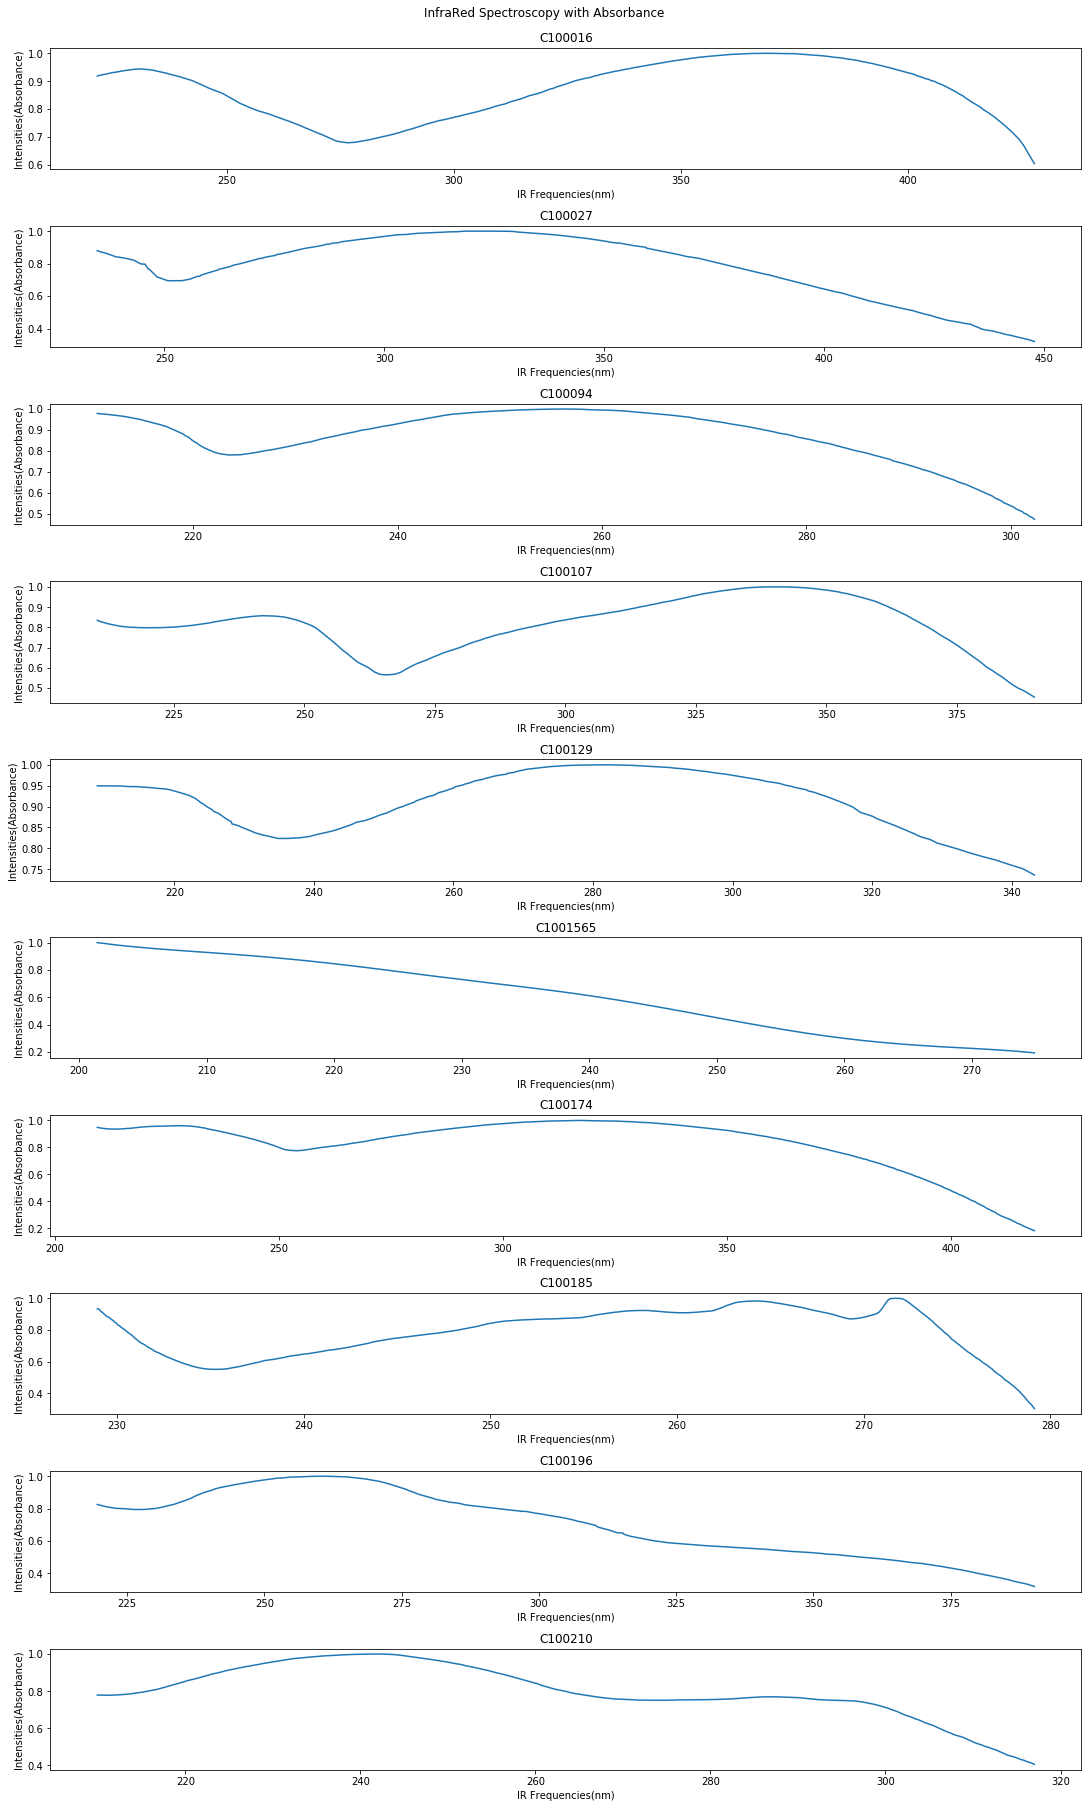

In [3]:
#Intensities are in logarithmic Episilon(nanometer) converting to Absorbance(centimeter^-1)
for i in range(len(df)):
    max_epsilon = df[i].iloc[:,1].max()
    df[i].iloc[:,1] = df[i].iloc[:,1] / max_epsilon
    df[i].columns = ['IR Frequencies(nm)','Intensities(Absorbance)']
    df[i].sort_values(by=['IR Frequencies(nm)'])
    print(df[i].head())

fig2,ax = plt.subplots(10,1,figsize=(15,25),constrained_layout=True)
for i in range(10):
    ax[i].plot(df[i].iloc[:,0],df[i].iloc[:,1])
    ax[i].set_xlabel('IR Frequencies(nm)')
    ax[i].set_ylabel('Intensities(Absorbance)')
    ax[i].title.set_text(df[i].index.name)
plt.suptitle('InfraRed Spectroscopy with Absorbance')
fig2.savefig('./Visualizations/Graphs/InfraRed_Spectroscopy_with_Absorbance')
plt.show()

### Interpolating
Making the wavelength range uniform across all dataframes using Index Interpolatting (Normalizing wavelength)

IR Frequencies(nm)  Intensities(Absorbance)
C100016                                             
0                   74.7145                      NaN
1                   94.7145                      NaN
2                  114.7145                      NaN
3                  134.7145                      NaN
4                  154.7145                      NaN
...                     ...                      ...
230                814.7145                 0.604729
231                834.7145                 0.604729
232                854.7145                 0.604729
233                874.7145                 0.604729
234                894.7145                 0.604729

[235 rows x 2 columns]
         IR Frequencies(nm)  Intensities(Absorbance)
C100027                                             
0                   74.7145                      NaN
1                   94.7145                      NaN
2                  114.7145                      NaN
3                  134.7145    

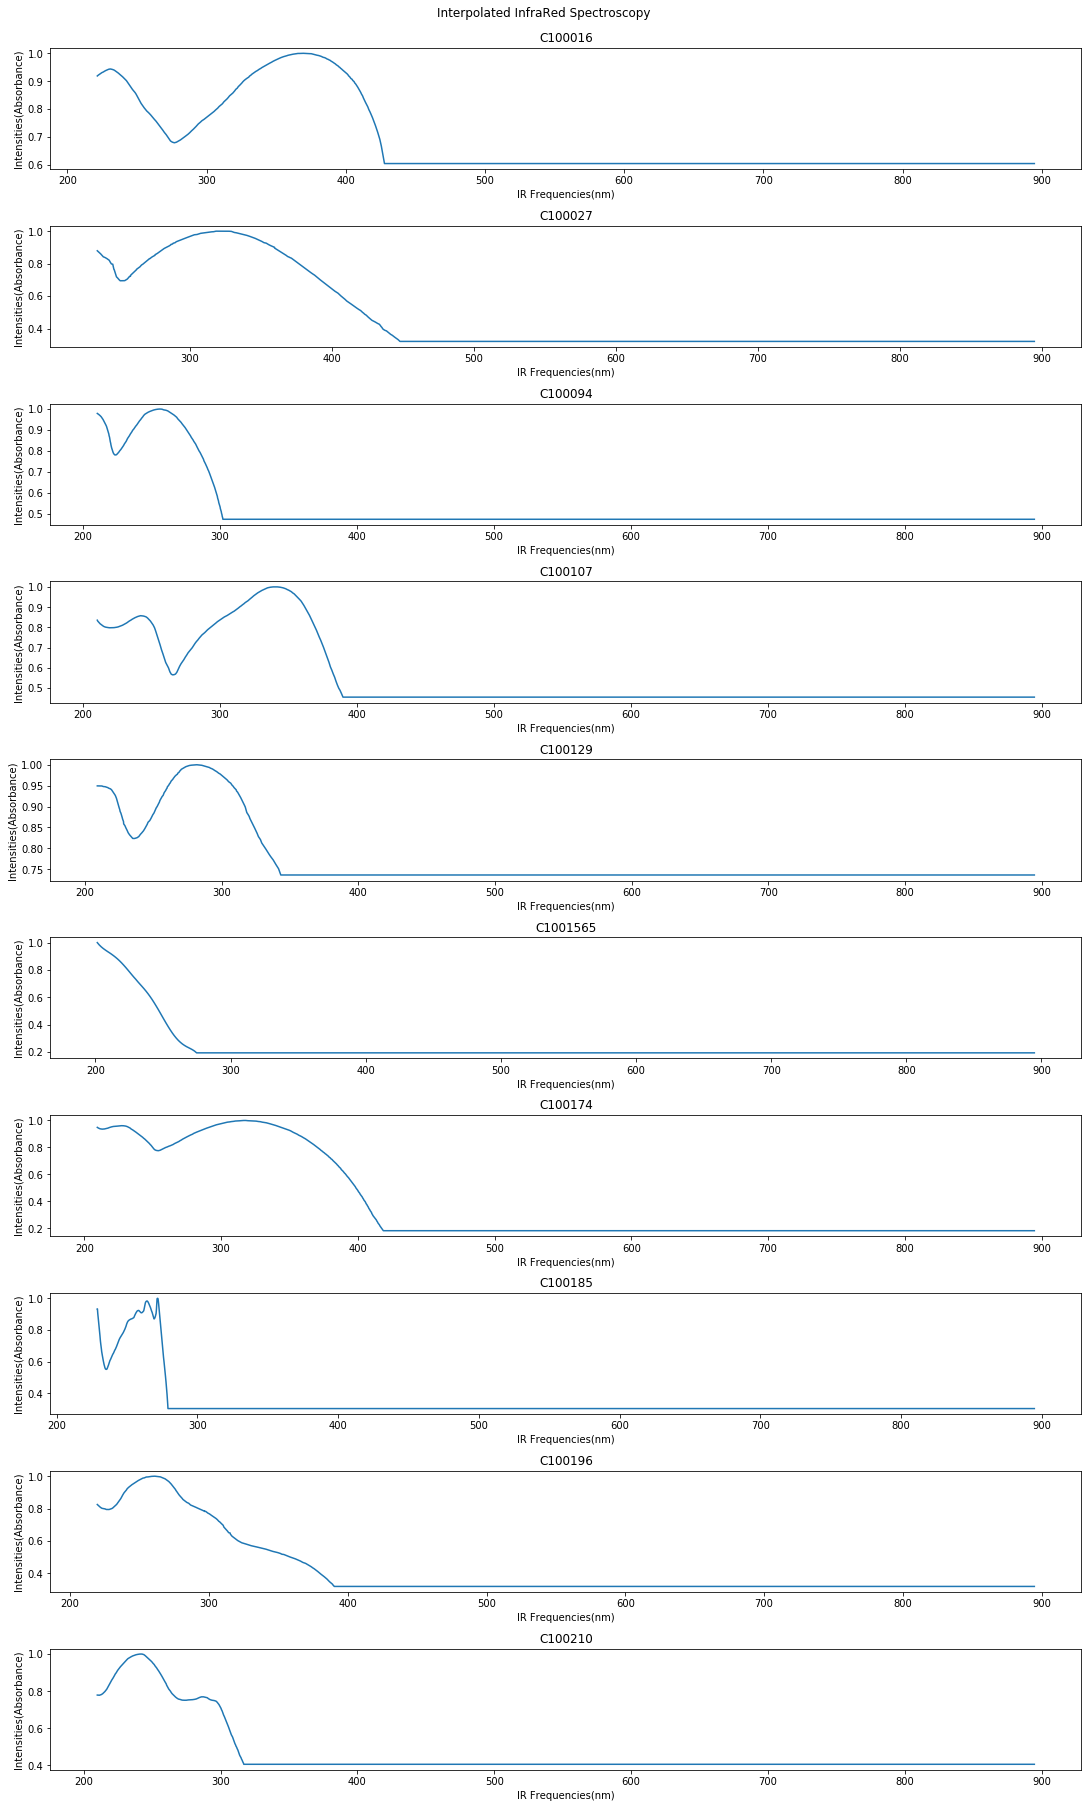

In [4]:
#The Max wavelength observed in the data is 899.347cm-1, while the Min wavelength observed is 74.7145cm-1. Thus a uniform range between max and min across all the dataframes
arr = np.arange(74.7145,899.347,20).astype(float)
dict1 = {'IR Frequencies(nm)':arr,'Intensities(Absorbance)':np.nan}
df_filler = pd.DataFrame(dict1)
for i,dataframe in enumerate(df):
    product = dataframe.index.name
    df_new = pd.concat([dataframe,df_filler])
    df_new.sort_values('IR Frequencies(nm)',inplace=True)
    df_new.set_index('IR Frequencies(nm)',inplace=True,drop=True)
    df_new.interpolate(method='index',inplace=True)
    df_new.reset_index(inplace=True)
    df_new.index.name = product
    df[i] = df_new
    print(df[i])

fig3,ax = plt.subplots(10,1,figsize=(15,25),constrained_layout=True)
for i in range(10):
    ax[i].plot(df[i].loc[:,'IR Frequencies(nm)'],df[i].loc[:,'Intensities(Absorbance)'])
    ax[i].set_xlabel('IR Frequencies(nm)')
    ax[i].set_ylabel('Intensities(Absorbance)')
    ax[i].title.set_text(df[i].index.name)
plt.suptitle('Interpolated InfraRed Spectroscopy')
fig3.savefig('./Visualizations/Graphs/Interpolated_IR_Spectroscopy')
plt.show()

### Converting into Single Dataframe
Each row as a sample product, the columns containing Intensities for each wavelength as features (Single Dataframe for features data) 

In [5]:
for i in range(0,len(df)):
    product = df[i].index.name
    df[i].set_index('IR Frequencies(nm)',drop=True,inplace=True)
    df[i].index.name = product
    print('Merging ',i,'dataframe')
    if i==1:
        data = df[0].merge(df[1],how='inner',left_index=True,right_index=True,sort=True)
    elif i>1:
        data = data.merge(df[i],how='inner',left_index=True,right_index=True,sort=True)
col_names = []
for i in range(len(df)):
    col_names.append(df[i].index.name)
data.columns = col_names
data.index.name = 'IR Frequencies(nm)'
print(data.head())

Merging  0 dataframe
Merging  1 dataframe
Merging  2 dataframe
Merging  3 dataframe
Merging  4 dataframe
Merging  5 dataframe
Merging  6 dataframe
Merging  7 dataframe
Merging  8 dataframe
Merging  9 dataframe
Merging  10 dataframe
Merging  11 dataframe
Merging  12 dataframe
Merging  13 dataframe
Merging  14 dataframe
Merging  15 dataframe
Merging  16 dataframe
Merging  17 dataframe
Merging  18 dataframe
Merging  19 dataframe
Merging  20 dataframe
Merging  21 dataframe
Merging  22 dataframe
Merging  23 dataframe
Merging  24 dataframe
Merging  25 dataframe
Merging  26 dataframe
Merging  27 dataframe
Merging  28 dataframe
Merging  29 dataframe
Merging  30 dataframe
Merging  31 dataframe
Merging  32 dataframe
Merging  33 dataframe
Merging  34 dataframe
Merging  35 dataframe
Merging  36 dataframe
Merging  37 dataframe
Merging  38 dataframe
Merging  39 dataframe
Merging  40 dataframe
Merging  41 dataframe
Merging  42 dataframe
Merging  43 dataframe
Merging  44 dataframe
Merging  45 datafram

### Transforming dataframe

In [6]:
data  = data.transpose()
data.index.name = 'Compounds'
data.columns.name = 'Wavelengths(cm-1)'
print(data.head())

Wavelengths(cm-1)  74.7145   74.7145   94.7145   114.7145  134.7145  154.7145  \
Compounds                                                                       
C100016                 NaN       NaN       NaN       NaN       NaN       NaN   
C100027                 NaN       NaN       NaN       NaN       NaN       NaN   
C100094                 NaN       NaN       NaN       NaN       NaN       NaN   
C100107                 NaN       NaN       NaN       NaN       NaN       NaN   
C100129                 NaN       NaN       NaN       NaN       NaN       NaN   

Wavelengths(cm-1)  174.7145  194.7145  214.7145  234.7145  ...  714.7145  \
Compounds                                                  ...             
C100016                 NaN       NaN       NaN  0.935869  ...  0.604729   
C100027                 NaN       NaN       NaN       NaN  ...  0.320492   
C100094                 NaN       NaN  0.951098  0.880573  ...  0.474528   
C100107                 NaN       NaN  0.806019  0.8

### Removing NaN values

In [7]:
data.fillna(method='bfill',axis=1,inplace=True)
data.fillna(method='ffill',axis=1,inplace=True)

#removing duplicate 74.7415 column
data = data.iloc[:,1:]

print(data.head())

Wavelengths(cm-1)  74.7145   94.7145   114.7145  134.7145  154.7145  174.7145  \
Compounds                                                                       
C100016            0.935869  0.935869  0.935869  0.935869  0.935869  0.935869   
C100027            0.698572  0.698572  0.698572  0.698572  0.698572  0.698572   
C100094            0.951098  0.951098  0.951098  0.951098  0.951098  0.951098   
C100107            0.806019  0.806019  0.806019  0.806019  0.806019  0.806019   
C100129            0.947463  0.947463  0.947463  0.947463  0.947463  0.947463   

Wavelengths(cm-1)  194.7145  214.7145  234.7145  254.7145  ...  714.7145  \
Compounds                                                  ...             
C100016            0.935869  0.935869  0.935869  0.807943  ...  0.604729   
C100027            0.698572  0.698572  0.698572  0.698572  ...  0.320492   
C100094            0.951098  0.951098  0.880573  0.999221  ...  0.474528   
C100107            0.806019  0.806019  0.834883  0.7

### Visualizing Final Dataframe

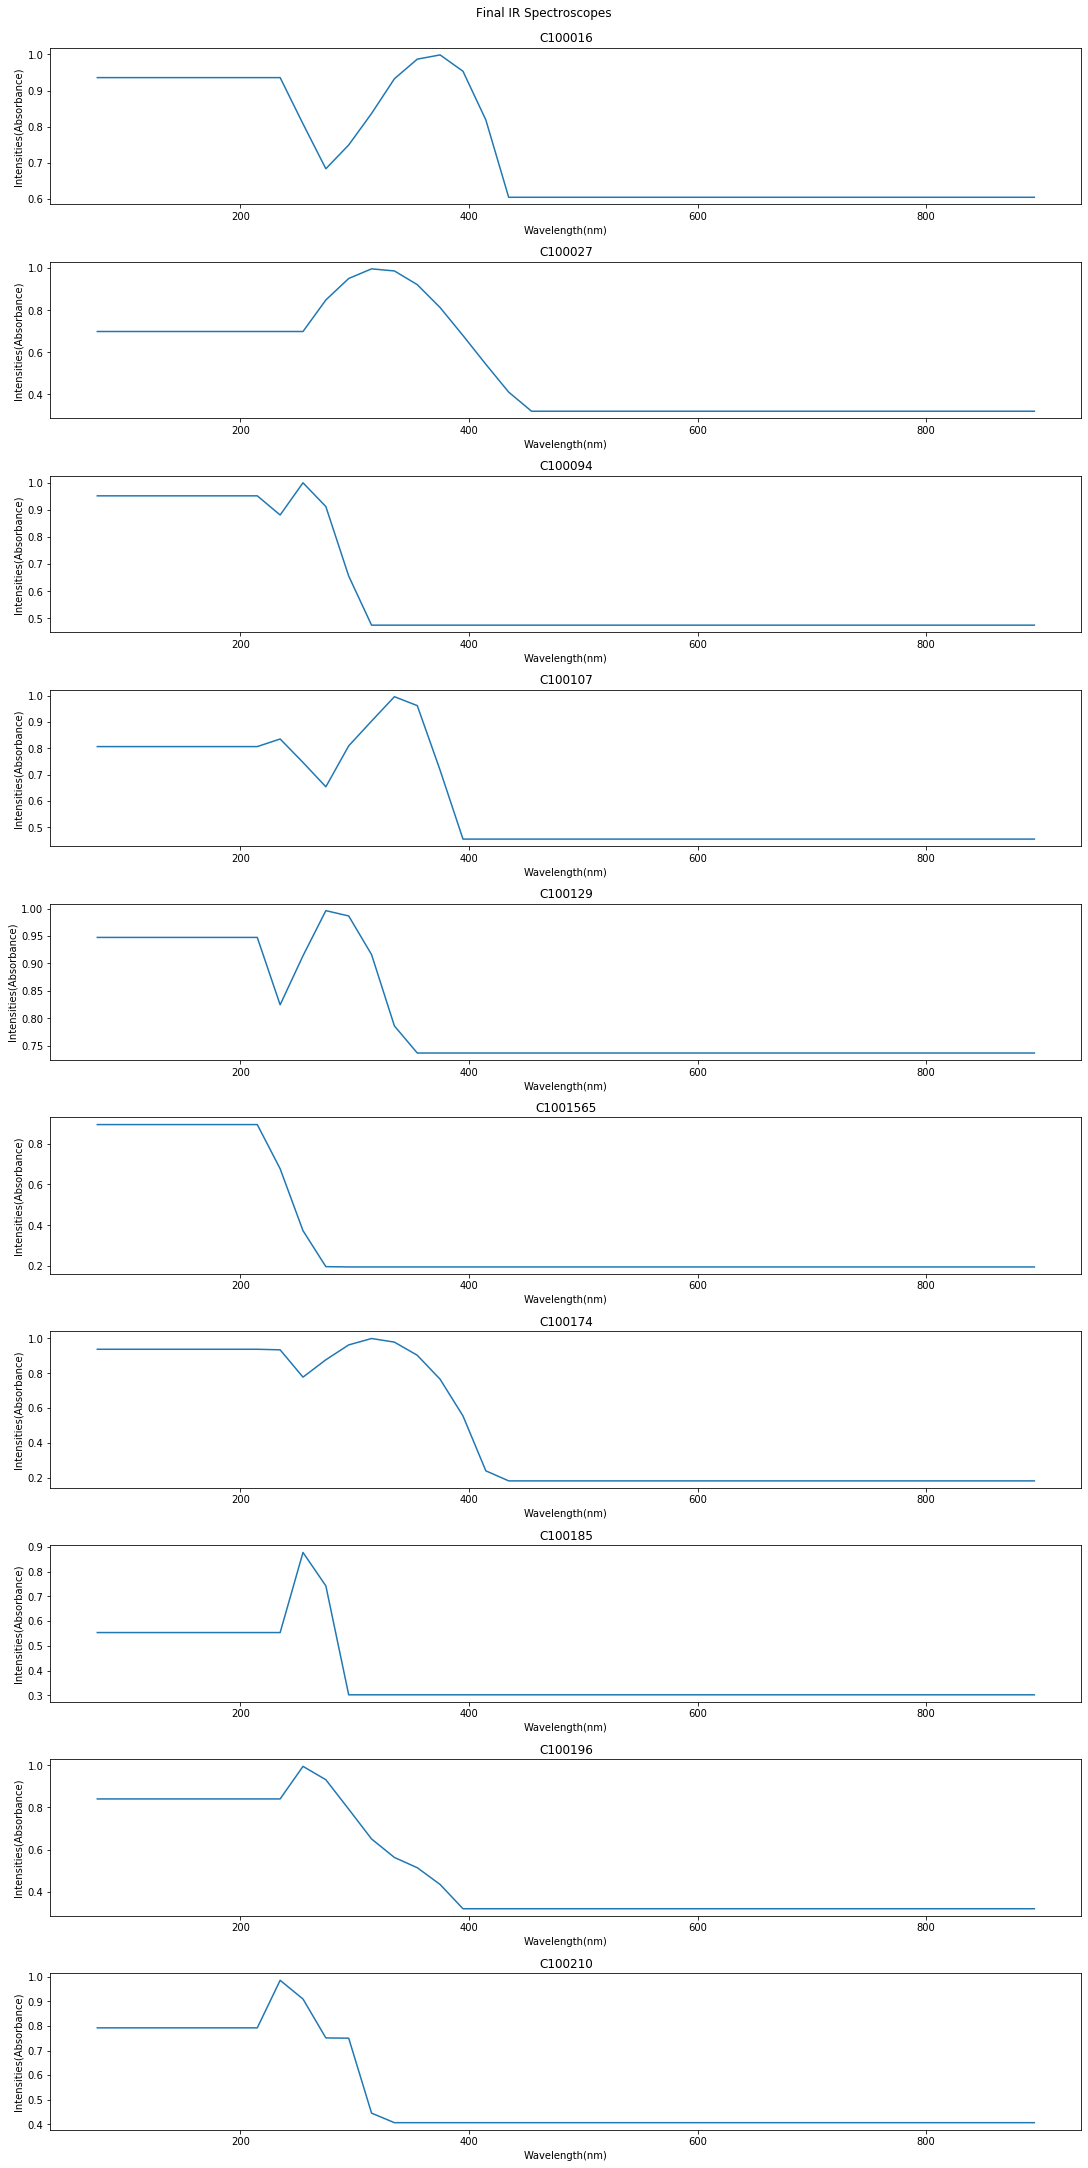

In [8]:
fig4,ax = plt.subplots(10,1,figsize=(15,30),constrained_layout=True)
compounds = data.index.tolist()
for i in range(10):
    ax[i].plot(data.columns.tolist(),data.iloc[i,:])
    ax[i].set_xlabel('Wavelength(nm)')
    ax[i].set_ylabel('Intensities(Absorbance)')
    ax[i].title.set_text(compounds[i])
plt.suptitle("Final IR Spectroscopes")
fig4.savefig('./Visualizations/Graphs/Final_Spectrscopes.png')
plt.show()

## Data Processing

### Validating PCA

Variance considered = 99.54194798756756% ; Number of PCA Components = 10 ; svd_solver = 'fill'


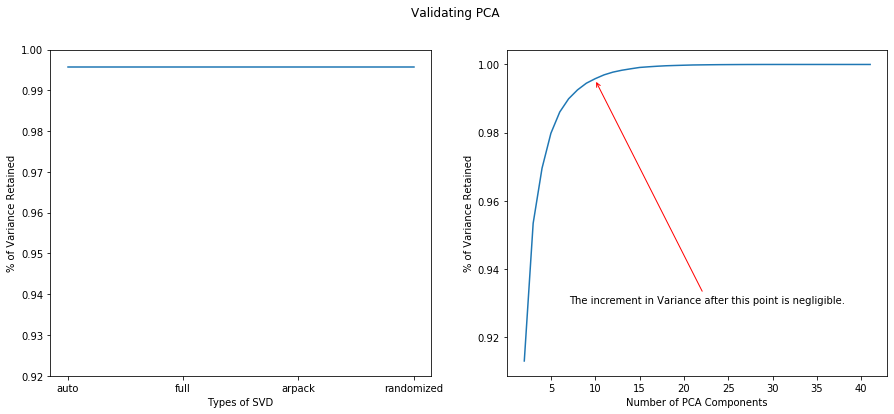

In [9]:
from sklearn.decomposition import PCA

fig5,ax = plt.subplots(1,2,figsize=(15,6))

svd=['auto', 'full', 'arpack', 'randomized']
scores_1 = []
for s in svd:
    pca_1 = PCA(n_components=10,svd_solver=s)
    pca_1.fit(data)
    compressed = pca_1.transform(data)
    scores_1.append(pca_1.explained_variance_ratio_.cumsum()[-1])
ax[0].plot(range(4),scores_1)
ax[0].set_xlabel("Types of SVD")
ax[0].set_ylabel("% of Variance Retained")
ax[0].set_xticks(range(4))
ax[0].set_xticklabels(svd)
ax[0].set_ylim([0.92,1.0])

scores_2 = []
for i in range(2,42):
    pca = PCA(n_components=i,svd_solver='full')
    pca.fit(data)
    compressed = pca.transform(data)
    scores_2.append(pca.explained_variance_ratio_.cumsum()[-1])
ax[1].plot(range(2,42),scores_2)
ax[1].set_xlabel("Number of PCA Components")
ax[1].set_ylabel("% of Variance Retained")
ax[1].annotate("The increment in Variance after this point is negligible.",xy=[10,0.9954194798756756],xytext=[7,0.93],arrowprops={'arrowstyle':'->','color':'r'})
print("Variance considered = 99.54194798756756% ; Number of PCA Components = 10 ; svd_solver = 'fill'")

plt.suptitle("Validating PCA")
fig5.savefig('./Visualizations/Graphs/PCA_Componenets_Validation.png')
plt.show()

### PCA implementation
Using the above Validated parameters 

In [10]:
pca = PCA(n_components=20,svd_solver='full')
pca.fit(data)
compressed = pca.transform(data)
col_names = []
for i in range(1,21):
    col_names.append('PCA Component '+str(i))
features = pd.DataFrame(compressed,columns=col_names)
features.set_index(data.index,inplace=True,drop=True)
print(features)


PCA Component 1  PCA Component 2  PCA Component 3  PCA Component 4  \
Compounds                                                                       
C100016          -0.771745        -0.149100         0.143845         0.568135   
C100027           0.620631        -0.056516         1.022780         0.534720   
C100094           0.289391        -0.138104        -0.151236        -0.232735   
C100107           0.180197        -0.027867         0.492176         0.321717   
C100129          -1.206482        -0.046454         0.054897        -0.111367   
...                    ...              ...              ...              ...   
C99934           -0.594350         0.192607        -0.006439        -0.147293   
C99945            0.598793         0.200868        -0.092493        -0.143106   
C99967            2.255177         1.670549         0.465526         0.209163   
C99978            0.574637         0.005376         0.095998        -0.222425   
C99990            1.172787        -0.58

### Uniforming samples across data and labels

In [11]:
#Making data and labels have equal samples
labels = labels.loc[data.index.tolist(),:]
print(labels.shape)

(2099, 11)


### Converting Pandas Dataframes to Numpy Arrays

In [12]:
targets = labels.values
features = data.values.astype(float)

from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(features, targets, random_state=42, test_size=0.2)
print('Features Train\n',xtrain,'\n\nTarget Train\n',ytrain)

Features Train
 [[0.92996582 0.92996582 0.92996582 ... 0.89885808 0.89885808 0.89885808]
 [0.91440084 0.91440084 0.91440084 ... 0.79873551 0.79873551 0.79873551]
 [0.98436257 0.98436257 0.98436257 ... 0.09234694 0.09234694 0.09234694]
 ...
 [0.97402463 0.97402463 0.97402463 ... 0.8185118  0.8185118  0.8185118 ]
 [0.96737218 0.96737218 0.96737218 ... 0.12392731 0.12392731 0.12392731]
 [0.97716382 0.97716382 0.97716382 ... 0.70267019 0.70267019 0.70267019]] 

Target Train
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 1 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


### Model Training
Neural Network using sigmoid activator and backpropogation

### Importing Libraries for Model Training 

In [13]:
from keras import layers
from keras import models
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras import initializers
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras.losses import BinaryCrossentropy
from keras.utils import model_to_dot

### Validating Nueral Network
Number of activation nodes for each hidden layer 

In [18]:
#Define optimizer
sgd = SGD(learning_rate=0.01,momentum=0.8,nesterov=False)

#Define Loss Function
loss_fn = BinaryCrossentropy(name="binary_crossentropy")

def create_model(layers) :
    model = Sequential()
    for i,nodes in enumerate(layers):
        if i==0:
            model.add(Dense(nodes,input_dim=xtrain.shape[1]))
            model.add(Activation('sigmoid'))
        else:
            model.add(Dense(nodes))
            model.add(Activation('sigmoid'))
        
    model.add(Dense(ytrain.shape[1],kernel_initializer=initializers.RandomNormal(stddev=0.01),activation='softmax'))

    model.compile(optimizer=sgd,loss=loss_fn,metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)

layers = [[50,50],[100,100],[150,150],[200,200],[250,250]]
param_grid = dict(layers=layers,epochs=[50,75,100],batch_size=[128,256,512])
grid = GridSearchCV(estimator=model, param_grid=param_grid,cv=4)
grid_result = grid.fit(features,targets)

print('The Best Accuracy attained is: ',grid_result.best_score_,'\nThe best Parameters to use: ',grid_result.best_params_)
print('\nResults:\n\n',pd.DataFrame(grid_result.cv_results_))

The Best Accuracy attained is:  0.8013339474577175 
The best Parameters to use:  {'batch_size': 128, 'epochs': 50, 'layers': [50, 50]}

Results:

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        2.382968      0.101912         0.088471        0.015306   
1        2.746857      0.199910         0.133036        0.020262   
2        3.233657      0.563973         0.229963        0.019404   
3        3.855199      0.672945         0.287483        0.069377   
4        4.500018      0.661108         0.372410        0.079513   
5        3.858254      0.853835         0.388732        0.077178   
6        4.703169      0.589385         0.485059        0.077804   
7        5.758475      0.618822         0.600579        0.085657   
8        6.399442      0.653383         0.748228        0.104889   
9        7.188743      0.824220         0.945605        0.033035   
10       7.547975      0.498139         1.017094        0.156644   
11       9.260449      0.172781      

### Splitting Data into Train and Validation Data

In [15]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(features,targets,random_state=42,test_size=0.2)

### Training Nueral Network
Based upon the above validated nueral architecture

In [16]:
sgd_validated = SGD(learning_rate=0.01,momentum=0.8,nesterov=False)

loss_fn = BinaryCrossentropy(name="binary_crossentropy")

classifier = Sequential()

classifier.add(Dense(50,activation='sigmoid',input_dim=xtrain.shape[1],name='hidden_layer_1'))
classifier.add(Dense(50,activation='sigmoid',name='hidden_layer_2'))
classifier.add(Dense(ytrain.shape[1],activation='softmax',name='output_layer'))

classifier.compile(optimizer=sgd_validated, loss=loss_fn)

classifier.fit(xtrain,ytrain,validation_data=(xtest,ytest),batch_size=128,epochs=50)

Train on 1679 samples, validate on 420 samples
Epoch 1/50
1679/1679 [==============================] - 7s 4ms/step - loss: 0.4797 - val_loss: 0.4697
Epoch 2/50
1679/1679 [==============================] - 0s 41us/step - loss: 0.4434 - val_loss: 0.4400
Epoch 3/50
1679/1679 [==============================] - 0s 41us/step - loss: 0.4216 - val_loss: 0.4250
Epoch 4/50
1679/1679 [==============================] - 0s 41us/step - loss: 0.4106 - val_loss: 0.4173
Epoch 5/50
1679/1679 [==============================] - 0s 44us/step - loss: 0.4047 - val_loss: 0.4130
Epoch 6/50
1679/1679 [==============================] - 0s 46us/step - loss: 0.4010 - val_loss: 0.4102
Epoch 7/50
1679/1679 [==============================] - 0s 47us/step - loss: 0.3986 - val_loss: 0.4084
Epoch 8/50
1679/1679 [==============================] - 0s 44us/step - loss: 0.3967 - val_loss: 0.4068
Epoch 9/50
1679/1679 [==============================] - 0s 45us/step - loss: 0.3953 - val_loss: 0.4057
Epoch 10/50
1679/1679 [====

### Visualizing Trained Model

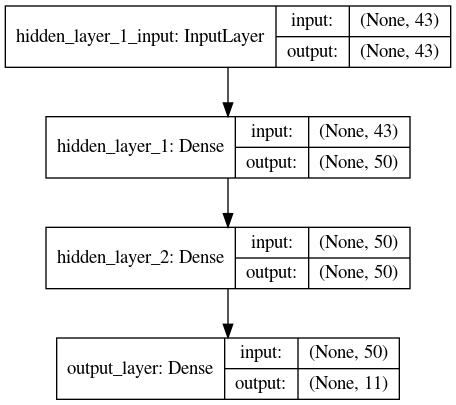

In [17]:
model_plot = model_to_dot(classifier,show_shapes=True, show_layer_names=True)
model_plot.write_png('./Visualizations/Model.png')

from IPython.display import Image
Image(filename = './Visualizations/Model.png')